<a href="https://colab.research.google.com/github/stopthecap10/MultiModelEnsemblePrediction/blob/main/Stock_Market_Predictor_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

# Stock Market Predictor

Mount drive to store data

In [ ]:
# Mount drive for data
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive is already mounted.")

Mounted at /content/drive


In [ ]:
#import libraries
import yfinance as yf
import pandas as pd
import numpy as np
#setup
#code
tickers = {
    "Apple": "AAPL",
    "Coca-Cola": "KO",
    "Amazon": "AMZN",
    "Nike": "NKE",
    "Tesla": "TSLA",
    "Microsoft": "MSFT"
}

base_path = "/content/drive/MyDrive/Colab Notebooks/data/"


## Get Stock ticker data from Yahoo and write them to files

In [ ]:
#Not required to run if data already exists

for sym in tickers.items():
  file = base_path + "data_" + sym[1] + ".csv"
  if os.path.exists(file):
    print(f"Data for {sym[1]} already exists. Skipping download.")
  else:
    print("Getting..." + sym[1])
    ticker = yf.Ticker(sym[1]) #import data
    stock_df = ticker.history(period="5y") #get data from 5 year period in dataframe
    stock_df.drop(['High','Close','Volume','Dividends','Stock Splits'], axis=1, inplace=True) #only have two columns, not seven
    print("Saving to " + file )
    stock_df.to_csv( file, index=False)

Data for AAPL already exists. Skipping download.
Data for KO already exists. Skipping download.
Data for AMZN already exists. Skipping download.
Data for NKE already exists. Skipping download.
Data for TSLA already exists. Skipping download.
Data for MSFT already exists. Skipping download.


## Helper function to prepare data

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # Progress bar

# Prepare stock data
def prepare_data(symbol):
    # Read from CSV instead of yfinance

    file = base_path + "data_" + symbol + ".csv"
    df = pd.read_csv(file)
    open_prices = df[['Open']].to_numpy()

    # Ensure enough data points for windowing
    window_size = 3
    if len(open_prices) < window_size + 1:
        print(f"Warning: Not enough data for {symbol} to create features.")
        return None, None, None, None


    X = np.zeros((len(open_prices) - (window_size + 1), window_size))
    Y = [0] * (len(open_prices) - (window_size + 1))

    for i in range(len(open_prices) - (window_size + 1)):
        X[i] = [open_prices[i][0], open_prices[i + 1][0], open_prices[i + 2][0]]
        Y[i] = open_prices[i + 3][0]

    return train_test_split(X, Y, test_size=0.33)

def save_to_file(results, file_name):
    # Convert results to DataFrame
    df_final = pd.DataFrame(results)
    print("Results: \n \n")
    print(df_final)
    file = base_path + file_name
    print("Saving to :" + file )
    df_final.to_csv( file, index=False)


# MLP, Decision Tree, RandomForest, Average Ensemble And Accuracy Ensemble


In [ ]:
# MLP, Decision Tree, RandomForest and Average Ensemble computation

# Configurations: (Depth/Hidden Layers, Neurons/Estimators, Max Iterations)
model_configs = [(1, 50, 100), (5, 50, 250), (10, 100, 500), (20, 200, 1000), (40, 400, 2000), (50, 500, 3000)]

# Cache data for faster runtime
data_cache = {}
for symbol in tickers.values():
    X_train, X_test, Y_train, Y_test = prepare_data(symbol)
    if X_train is not None:
        data_cache[symbol] = (X_train, X_test, Y_train, Y_test)

# Results table
mlp_results = []
dtr_results = []
rfr_results = []
avg_results = []
acc_results = []


# Define a small epsilon value to prevent division by zero
epsilon = 1e-10


for depth_layers, neurons_estimators, max_iter in tqdm(model_configs, desc="Running model configurations"):
    avg_row = {"Model Config (Depth/HL, Neurons/Estimators, Iter)": f"{depth_layers}, {neurons_estimators}, {max_iter}"}
    mlp_row = {"Model Config (Iter)": f"{max_iter}"}
    dtr_row = {"Model Config (Depth/HL)": f"{depth_layers}"}
    rfr_row = {"Model Config (Depth/HL, Neurons/Estimators)": f"{depth_layers}, {neurons_estimators}"}
    acc_row = {"Model Config (Depth/HL, Neurons/Estimators, Iter)": f"{depth_layers}, {neurons_estimators}, {max_iter}"}


    print("\n Working on..." + str(avg_row))

    for company, symbol in tickers.items():
        if symbol in data_cache:
            X_train, X_test, Y_train, Y_test = data_cache[symbol]

            # Train models
            linear = LinearRegression().fit(X_train, Y_train)
            mlp = MLPRegressor(hidden_layer_sizes=(neurons_estimators,) * depth_layers, max_iter=max_iter).fit(X_train, Y_train)
            dtr = DecisionTreeRegressor(max_depth=depth_layers).fit(X_train, Y_train)
            rfr = RandomForestRegressor(max_depth=depth_layers, n_estimators=neurons_estimators, n_jobs=-1).fit(X_train, Y_train)

            # Predictions
            pred_linear_test = linear.predict(X_test)
            pred_mlp_test = mlp.predict(X_test)
            pred_dtr_test = dtr.predict(X_test)
            pred_rfr_test = rfr.predict(X_test)

            pred_linear_train = linear.predict(X_train)
            pred_mlp_train = mlp.predict(X_train)
            pred_dtr_train = dtr.predict(X_train)
            pred_rfr_train = rfr.predict(X_train)

            #MLPRegressor MSE
            mlp_train_mse = mean_squared_error(Y_train, pred_mlp_train)
            mlp_test_mse = mean_squared_error(Y_test, pred_mlp_test)
            mlp_row[company] = (round(mlp_train_mse, 2), round(mlp_test_mse, 2))

            #DTR MSE
            dtr_train_mse = mean_squared_error(Y_train, pred_dtr_train)
            dtr_test_mse = mean_squared_error(Y_test, pred_dtr_test)
            dtr_row[company] = (round(dtr_train_mse, 2), round(dtr_test_mse, 2))

            #RFR MSE
            rfr_train_mse = mean_squared_error(Y_train, pred_rfr_train)
            rfr_test_mse = mean_squared_error(Y_test, pred_rfr_test)
            rfr_row[company] = (round(rfr_train_mse, 2), round(rfr_test_mse, 2))


            # Equal-weight ensemble
            ensemble_test = np.mean([pred_linear_test, pred_mlp_test, pred_dtr_test, pred_rfr_test], axis=0)
            ensemble_train = np.mean([pred_linear_train, pred_mlp_train, pred_dtr_train, pred_rfr_train], axis=0)

            # Ensemble MSE
            mse_test = mean_squared_error(Y_test, ensemble_test)
            mse_train = mean_squared_error(Y_train, ensemble_train)
            avg_row[company] = (round(mse_train, 2), round(mse_test, 2))

            #---------------------------
            # Accuracy based calculations
            linear_train_error = (1 / (mean_squared_error(Y_train, pred_linear_train) + epsilon))
            MLP_train_error = (1 / (mlp_train_mse + epsilon))
            DTR_train_error = (1 / (dtr_train_mse + epsilon))
            RFR_train_error = (1 / (rfr_train_mse + epsilon))

            inverse_train_sum = linear_train_error + MLP_train_error + DTR_train_error + RFR_train_error

            test_linear = linear_train_error / inverse_train_sum
            test_MLP = MLP_train_error / inverse_train_sum
            test_DTR = DTR_train_error / inverse_train_sum
            test_RFR = RFR_train_error / inverse_train_sum

            weighted_average_train = test_linear * pred_linear_train + test_MLP * pred_mlp_train + test_DTR * pred_dtr_train + test_RFR * pred_rfr_train

            linear_test_error = (1 / (mean_squared_error(Y_test, pred_linear_test) + epsilon))
            MLP_test_error = (1 / (mlp_test_mse + epsilon))
            DTR_test_error = (1 / (dtr_test_mse + epsilon))
            RFR_test_error = (1 / (rfr_test_mse + epsilon))

            inverse_test_sum = linear_test_error + MLP_test_error + DTR_test_error + RFR_test_error

            w_linear = linear_test_error / inverse_test_sum
            w_MLP = MLP_test_error / inverse_test_sum
            w_DTR = DTR_test_error / inverse_test_sum
            w_RFR = RFR_test_error / inverse_test_sum

            weighted_average_test = w_linear * pred_linear_test + w_MLP * pred_mlp_test + w_DTR * pred_dtr_test + w_RFR * pred_rfr_test

            # Accuracy Ensemble MSE
            accuracy_test_mse = mean_squared_error(Y_test, weighted_average_test)
            accuracy_train_mse = mean_squared_error(Y_train, weighted_average_train)
            acc_row[company] = (round(accuracy_train_mse, 2), round(accuracy_test_mse, 2))
            #-------------------------------------------------------

        else:
            mlp_row[company] = ("N/A", "N/A") # cases where data not loaded
            dtr_row[company] = ("N/A", "N/A")
            rfr_row[company] = ("N/A", "N/A")
            avg_row[company] = ("N/A", "N/A")
            acc_row[company] = ("N/A", "N/A")


    mlp_results.append(mlp_row)
    dtr_results.append(dtr_row)
    rfr_results.append(rfr_row)
    avg_results.append(avg_row)
    acc_results.append(acc_row)


# print and save to file
save_to_file(mlp_results, "OUTPUT_MLP_MSE.csv")
save_to_file(dtr_results, "OUTPUT_DTR_MSE.csv")
save_to_file(rfr_results, "OUTPUT_RFR_MSE.csv")
save_to_file(avg_results, "OUTPUT_AVG_MSE.csv")
save_to_file(acc_results, "OUTPUT_ACCURACY_MSE.csv")

Running model configurations:   0%|          | 0/6 [00:00<?, ?it/s]


 Working on...{'Model Config (Depth/HL, Neurons/Estimators, Iter)': '1, 50, 100'}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
Running model configurations:  17%|█▋        | 1/6 [00:04<00:22,  4.54s/it]


 Working on...{'Model Config (Depth/HL, Neurons/Estimators, Iter)': '5, 50, 250'}


Running model configurations:  33%|███▎      | 2/6 [00:11<00:24,  6.07s/it]


 Working on...{'Model Config (Depth/HL, Neurons/Estimators, Iter)': '10, 100, 500'}


Running model configurations:  50%|█████     | 3/6 [00:53<01:07, 22.42s/it]


 Working on...{'Model Config (Depth/HL, Neurons/Estimators, Iter)': '20, 200, 1000'}


Running model configurations:  67%|██████▋   | 4/6 [03:44<02:42, 81.02s/it]


 Working on...{'Model Config (Depth/HL, Neurons/Estimators, Iter)': '40, 400, 2000'}


Running model configurations:  83%|████████▎ | 5/6 [13:06<04:14, 254.62s/it]


 Working on...{'Model Config (Depth/HL, Neurons/Estimators, Iter)': '50, 500, 3000'}


Running model configurations: 100%|██████████| 6/6 [31:21<00:00, 313.58s/it]


Results: 
 

  Model Config (Iter)               Apple       Coca-Cola             Amazon  \
0                 100      (13.46, 14.64)     (0.74, 0.7)     (18.79, 16.35)   
1                 250      (13.26, 13.06)    (0.52, 0.52)      (13.72, 12.3)   
2                 500      (12.44, 12.29)    (0.55, 0.55)      (13.57, 12.3)   
3                1000       (13.0, 12.78)    (0.59, 0.54)     (20.45, 18.79)   
4                2000  (4509.46, 4380.03)  (64.67, 58.68)     (35.97, 32.55)   
5                3000   (1636.54, 1755.9)  (59.34, 56.63)  (2303.5, 2251.86)   

               Nike             Tesla               Microsoft  
0       (7.8, 6.65)  (139.95, 109.19)          (38.91, 42.31)  
1      (5.35, 4.98)   (116.58, 90.11)           (32.92, 35.3)  
2      (5.32, 4.98)  (149.49, 122.55)            (36.9, 40.1)  
3      (5.19, 4.89)  (167.11, 140.81)          (43.17, 45.17)  
4    (79.18, 83.34)  (403.18, 389.86)      (1520.95, 1527.89)  
5  (974.86, 933.52)  (249.79, 234.57)  (10

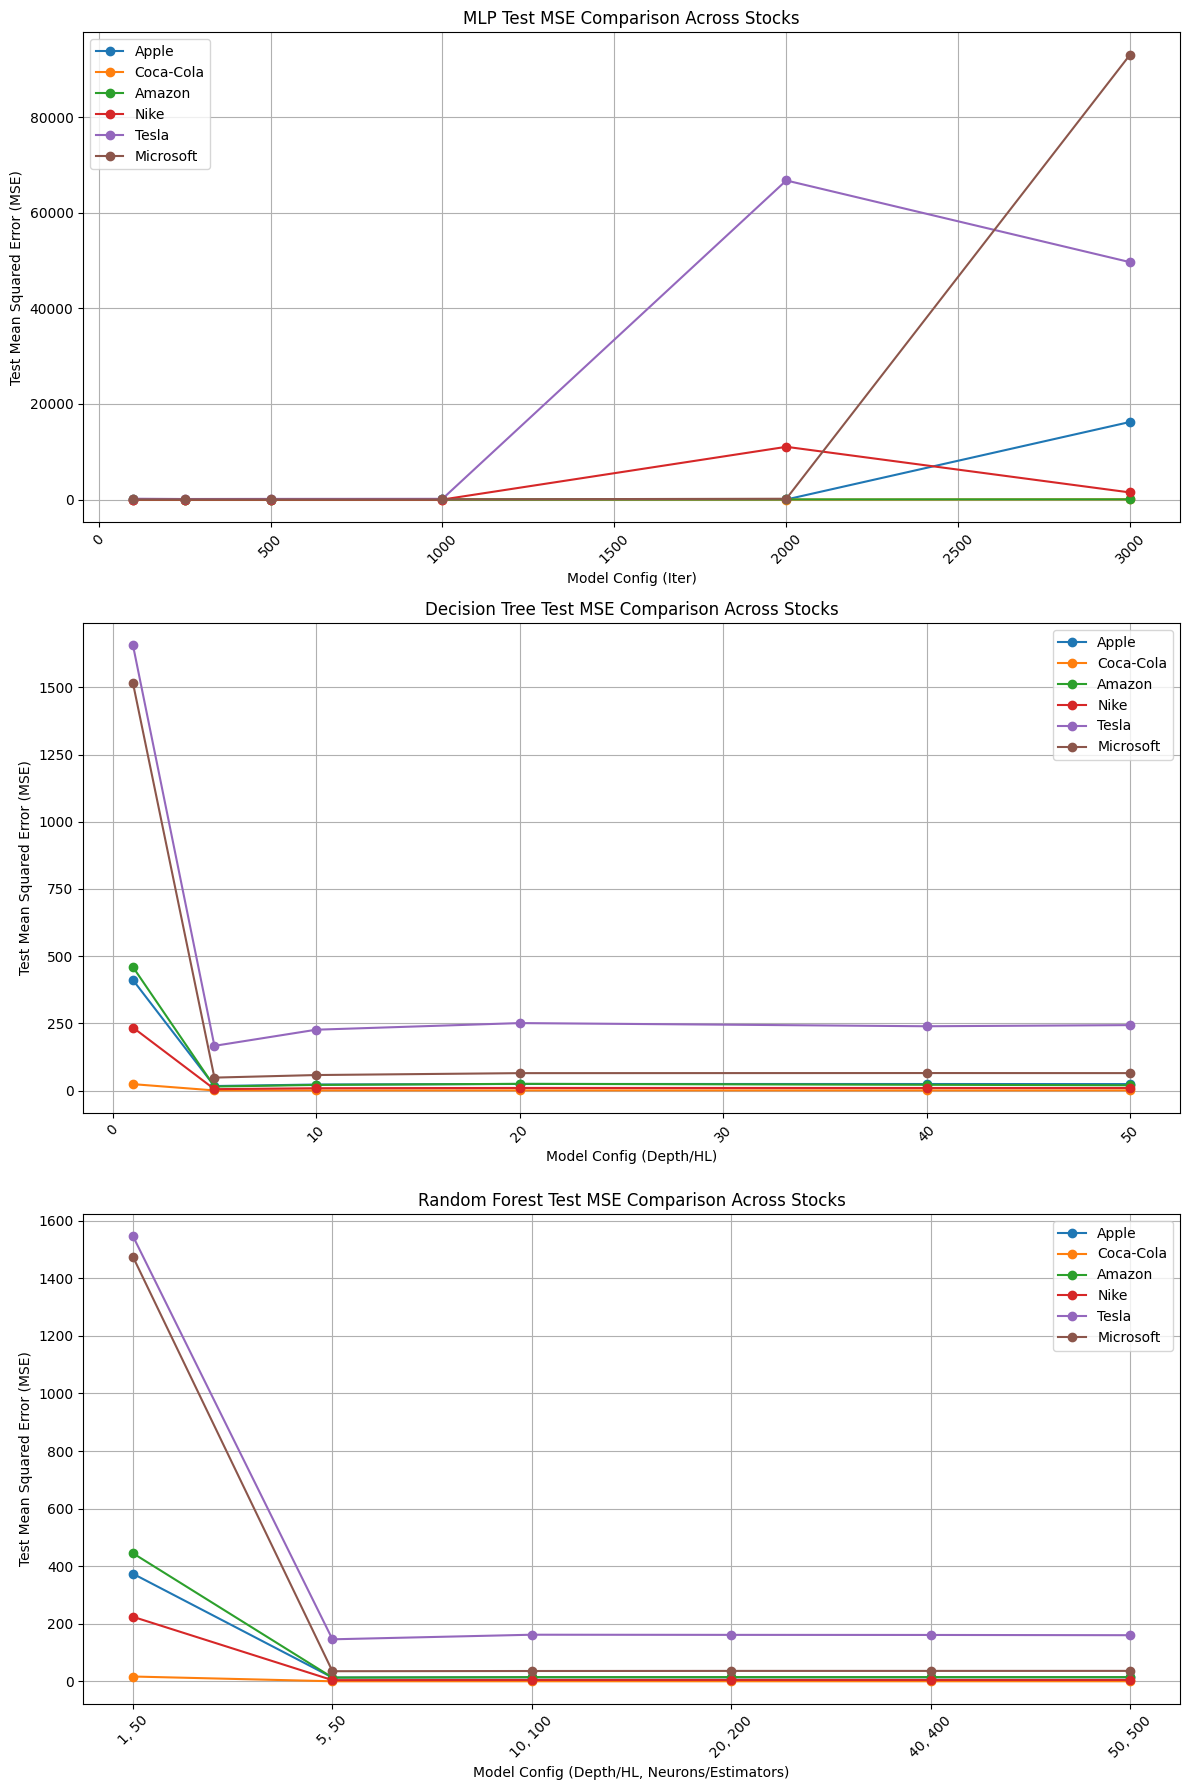

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV files
df_mlp_mse = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/OUTPUT_MLP_MSE.csv")
df_dtr_mse = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/OUTPUT_DTR_MSE.csv")
df_rfr_mse = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/OUTPUT_RFR_MSE.csv")

# Strip whitespace from column names
df_mlp_mse.columns = df_mlp_mse.columns.str.strip()
df_dtr_mse.columns = df_dtr_mse.columns.str.strip()
df_rfr_mse.columns = df_rfr_mse.columns.str.strip()

# Extract the model configurations for the x-axis
model_configs_mlp = df_mlp_mse['Model Config (Iter)']
model_configs_dtr = df_dtr_mse['Model Config (Depth/HL)']
model_configs_rfr = df_rfr_mse['Model Config (Depth/HL, Neurons/Estimators)']


# Get the list of stocks (excluding the config column) - assuming all files have the same stock columns
stocks = df_mlp_mse.columns.tolist()
stocks.remove('Model Config (Iter)')

# Function to extract Test MSE from a DataFrame column
def extract_test_mse(df, stock_col, config_col_name):
    # Extract the second element (Test MSE) from the tuple string
    mse_values = df[stock_col].astype(str).str.replace(r'\(|\)', '', regex=True).str.split(', ', expand=True)[1]
    return mse_values.astype(float)

# Create subplots for each model
models = {
    'MLP': (df_mlp_mse, model_configs_mlp, 'Model Config (Iter)'),
    'Decision Tree': (df_dtr_mse, model_configs_dtr, 'Model Config (Depth/HL)'),
    'Random Forest': (df_rfr_mse, model_configs_rfr, 'Model Config (Depth/HL, Neurons/Estimators)')
}

n_models = len(models)
fig, axes = plt.subplots(n_models, 1, figsize=(12, 6 * n_models))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, (model_name, (df, configs, config_col_name)) in enumerate(models.items()):
    ax = axes[i]
    for stock in stocks:
        test_mse = extract_test_mse(df, stock, config_col_name)
        ax.plot(configs, test_mse, marker='o', label=stock)

    ax.set_xlabel(config_col_name)
    ax.set_ylabel('Test Mean Squared Error (MSE)')
    ax.set_title(f'{model_name} Test MSE Comparison Across Stocks')
    ax.tick_params(axis='x', rotation=45) # Removed ha='right'
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Plot AVG And ACC MSE

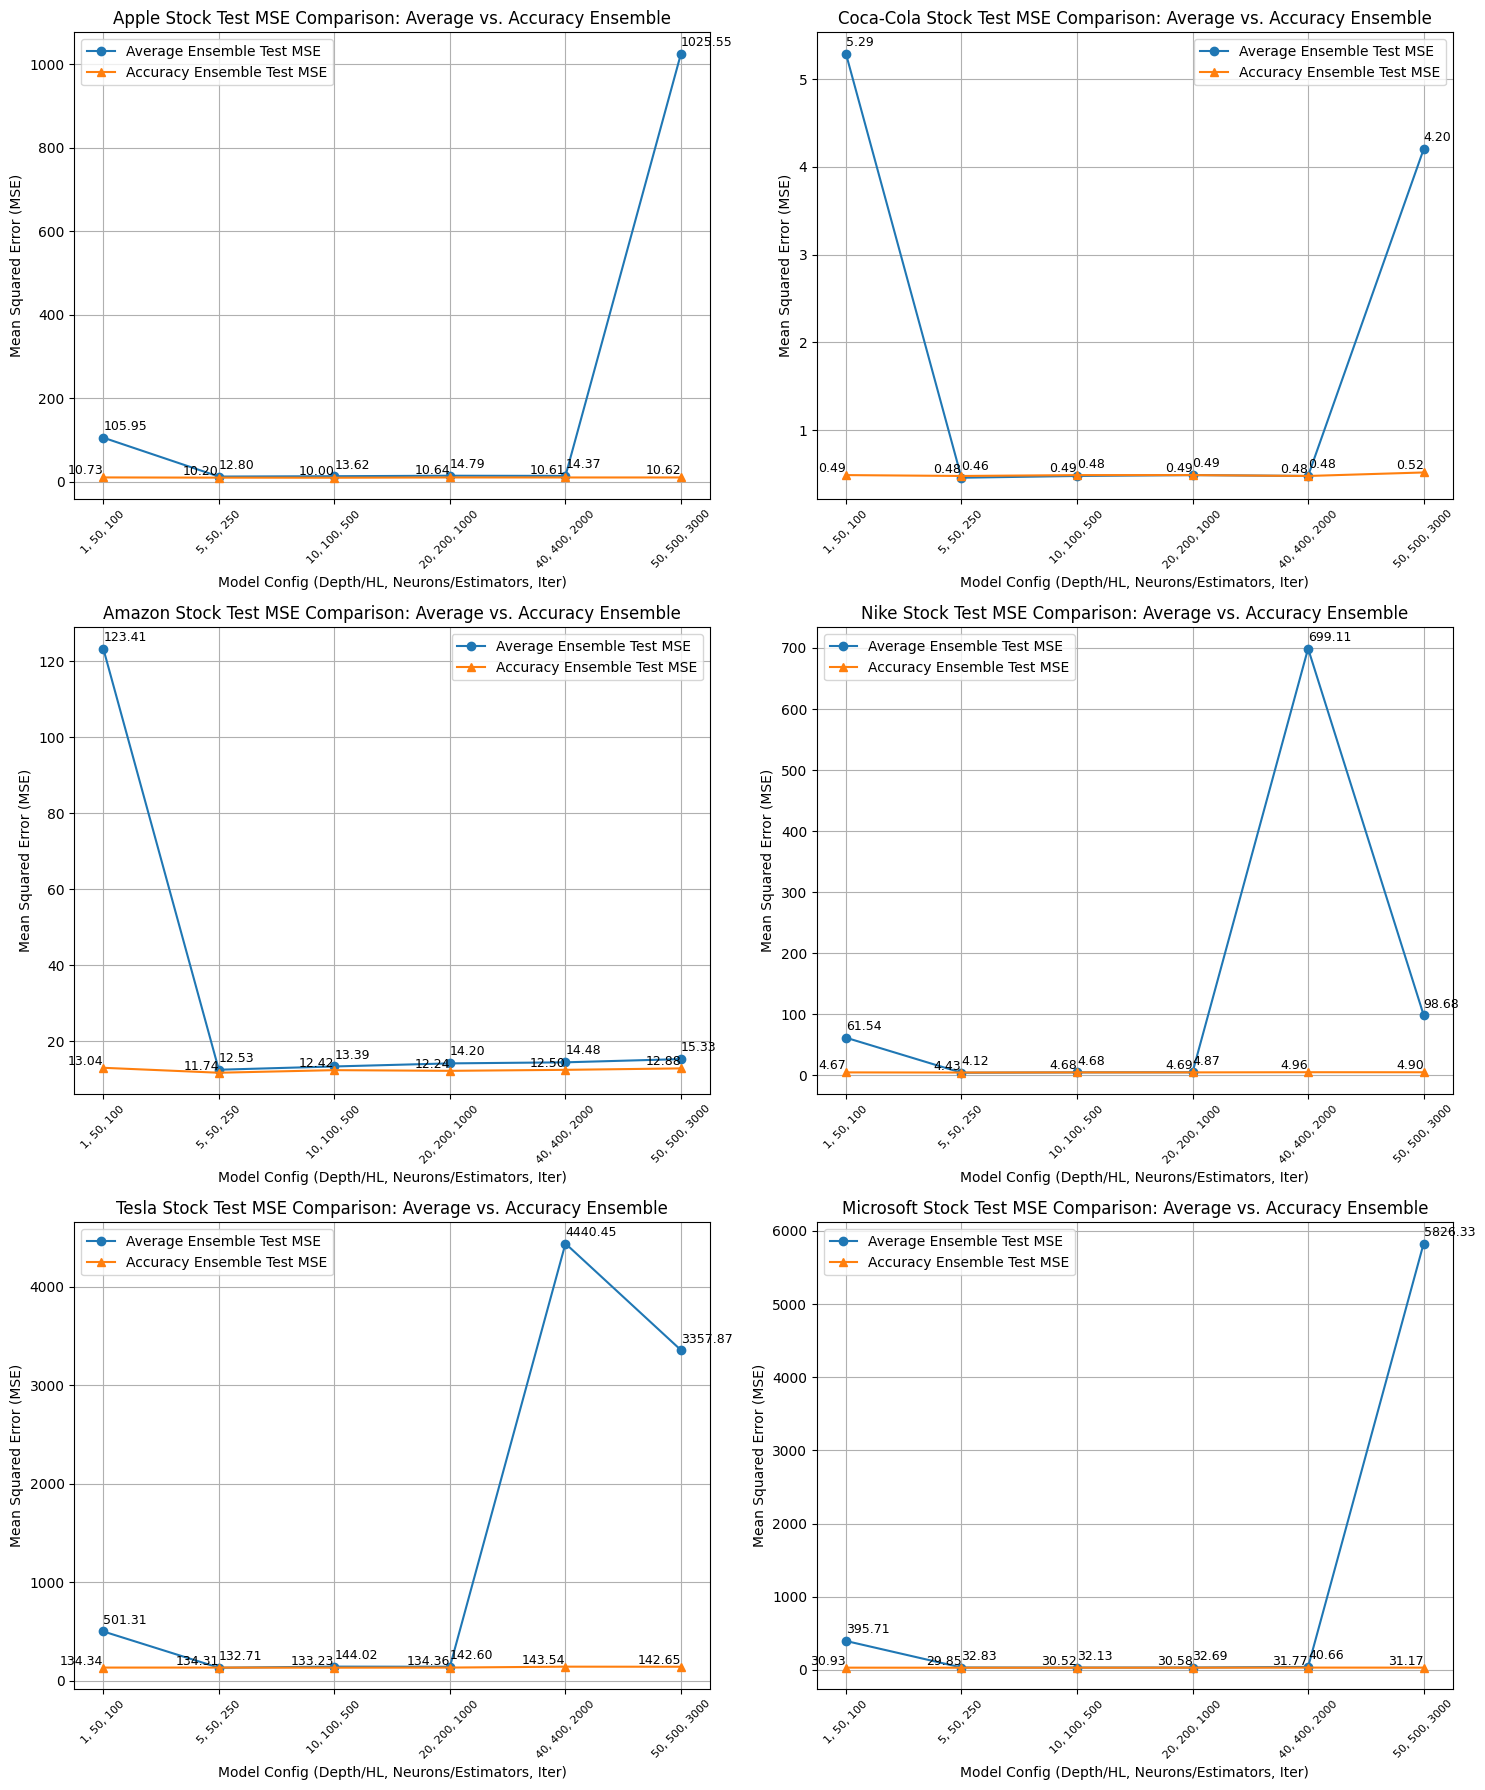

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV files
df_avg_mse = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/OUTPUT_AVG_MSE.csv")
df_acc_mse = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/OUTPUT_ACCURACY_MSE.csv")

# Strip whitespace from column names
df_avg_mse.columns = df_avg_mse.columns.str.strip()
df_acc_mse.columns = df_acc_mse.columns.str.strip()


# Extract the model configurations for the x-axis
model_configs = df_avg_mse['Model Config (Depth/HL, Neurons/Estimators, Iter)']

# Get the list of stocks (excluding the config column) - assuming both files have the same stock columns
stocks = df_avg_mse.columns.tolist()
stocks.remove('Model Config (Depth/HL, Neurons/Estimators, Iter)')

# Function to extract Test MSE from a DataFrame column
def extract_test_mse(df, stock_col):
    # Extract the second element (Test MSE) from the tuple string
    mse_values = df[stock_col].astype(str).str.replace(r'\(|\)', '', regex=True).str.split(', ', expand=True)[1]
    return mse_values.astype(float)

# Plot data with 2 plots per row
n_stocks = len(stocks)
n_rows = (n_stocks + 1) // 2 # Calculate number of rows needed (round up)

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 6 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, stock in enumerate(stocks):
    # Extract Test MSE for the current stock from both dataframes
    avg_test_mse = extract_test_mse(df_avg_mse, stock)
    acc_test_mse = extract_test_mse(df_acc_mse, stock)

    # Plot on the current axis
    ax = axes[i]
    ax.plot(model_configs, avg_test_mse, marker='o', label='Average Ensemble Test MSE')
    ax.plot(model_configs, acc_test_mse, marker='^', label='Accuracy Ensemble Test MSE') # Changed marker to triangle

    # Add labels to the data points
    for j, config in enumerate(model_configs):
        ax.text(config, avg_test_mse[j] + (ax.get_ylim()[1] * 0.01), f'{avg_test_mse[j]:.2f}', fontsize=9, ha='left', va='bottom') # Add offset to average labels
        ax.text(config, acc_test_mse[j], f'{acc_test_mse[j]:.2f}', fontsize=9, ha='right', va='bottom')

    ax.set_xlabel('Model Config (Depth/HL, Neurons/Estimators, Iter)')
    ax.set_ylabel('Mean Squared Error (MSE)')
    ax.set_title(f'{stock} Stock Test MSE Comparison: Average vs. Accuracy Ensemble')
    ax.tick_params(axis='x', rotation=45, labelsize=8) # Reduced label size
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
if n_stocks < len(axes):
    for j in range(n_stocks, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import pandas as pd # Import pandas for DataFrame creation and saving
import os # Import os for file path joining

# Define a small epsilon value to prevent division by zero
epsilon = 1e-10

# Define base_path and tickers if they are not already defined
# Assuming tickers and base_path are defined in a previous cell, but adding a fallback
if 'tickers' not in globals():
    tickers = {
        "Apple": "AAPL",
        "Coca-Cola": "KO",
        "Amazon": "AMZN",
        "Nike": "NKE",
        "Tesla": "TSLA",
        "Microsoft": "MSFT"
    }

if 'base_path' not in globals():
    base_path = "/content/drive/MyDrive/Colab Notebooks/data/"


# Define the prepare_data function if it's not already defined
# Assuming prepare_data is defined in a previous cell, but adding it here for independence
if 'prepare_data' not in globals():
    def prepare_data(symbol):
        # Read from CSV instead of yfinance
        file = base_path + "data_" + symbol + ".csv"
        if not os.path.exists(file):
            print(f"Data file not found for {symbol}: {file}")
            return None, None, None, None

        df = pd.read_csv(file)
        open_prices = df[['Open']].to_numpy()

        # Ensure enough data points for windowing
        window_size = 3
        if len(open_prices) < window_size + 1:
            print(f"Warning: Not enough data for {symbol} to create features.")
            return None, None, None, None

        X = np.zeros((len(open_prices) - (window_size + 1), window_size))
        Y = [0] * (len(open_prices) - (window_size + 1))

        for i in range(len(open_prices) - (window_size + 1)):
            X[i] = [open_prices[i][0], open_prices[i + 1][0], open_prices[i + 2][0]]
            Y[i] = open_prices[i + 3][0]

        return train_test_split(X, Y, test_size=0.33)

    # Import train_test_split if prepare_data is defined here
    from sklearn.model_selection import train_test_split


# Lists to store results for saving
equal_weight_results = []
accuracy_weight_results = []


for company, symbol in tqdm(tickers.items(), desc="Processing stocks"):
    # Load and prepare data for the current symbol
    X_train, X_test, Y_train, Y_test = prepare_data(symbol)

    if X_train is not None and len(X_train) > 0 and len(X_test) > 0:

        # Ensure enough data points for predictions
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping {company} due to insufficient training or testing data.")
            continue

        # Train models using the configuration that produced the best accuracy ensemble result
        # Based on the previous output, the best accuracy ensemble seems to be with config 50, 500, 3000
        # You might want to make this more dynamic based on the actual best config
        depth_layers, neurons_estimators, max_iter = 50, 500, 3000

        linear = LinearRegression().fit(X_train, Y_train)
        mlp = MLPRegressor(hidden_layer_sizes=(neurons_estimators,) * depth_layers, max_iter=max_iter, random_state=42).fit(X_train, Y_train)
        dtr = DecisionTreeRegressor(max_depth=depth_layers, random_state=42).fit(X_train, Y_train)
        rfr = RandomForestRegressor(max_depth=depth_layers, n_estimators=neurons_estimators, n_jobs=-1, random_state=42).fit(X_train, Y_train)

        # -----------------------------
        # 1) Per-model predictions
        # -----------------------------
        # Train/Test predictions
        pred_linear_train = linear.predict(X_train)
        pred_mlp_train    = mlp.predict(X_train)
        pred_dtr_train    = dtr.predict(X_train)
        pred_rfr_train    = rfr.predict(X_train)

        pred_linear_test = linear.predict(X_test)
        pred_mlp_test    = mlp.predict(X_test)
        pred_dtr_test    = dtr.predict(X_test)
        pred_rfr_test    = rfr.predict(X_test)

        # Full predictions over X (for trading sim)
        # Need to regenerate X and Y for the full dataset for this symbol
        file = base_path + "data_" + symbol + ".csv"
        df = pd.read_csv(file)
        open_prices = df[['Open']].to_numpy()

        window_size = 3
        if len(open_prices) < window_size + 1:
            print(f"Warning: Not enough data for {symbol} to create full predictions.")
            continue

        X = np.zeros((len(open_prices) - (window_size + 1), window_size))
        Y = [0] * (len(open_prices) - (window_size + 1))

        for i in range(len(open_prices) - (window_size + 1)):
            X[i] = [open_prices[i][0], open_prices[i + 1][0], open_prices[i + 2][0]]
            Y[i] = open_prices[i + 3][0]


        pred_linear_full = linear.predict(X)
        pred_mlp_full    = mlp.predict(X)
        pred_dtr_full    = dtr.predict(X)
        pred_rfr_full    = rfr.predict(X)


        # Basic sanity checks
        N = len(Y)
        assert len(pred_linear_full) == len(pred_mlp_full) == len(pred_dtr_full) == len(pred_rfr_full) == N, "Length mismatch in full predictions vs Y"
        assert len(pred_linear_test) == len(Y_test),  "Test prediction length mismatch"
        assert len(pred_linear_train) == len(Y_train), "Train prediction length mismatch"

        # -----------------------------
        # 2) Equal-weight ensemble (full)
        # -----------------------------
        equal_pred_full = (pred_linear_full + pred_mlp_full + pred_dtr_full + pred_rfr_full) / 4.0

        # -----------------------------
        # 3) Accuracy-weighted ensemble via inverse MSE (your exact method)
        #    We'll compute TRAIN and TEST weights; we'll USE TEST weights for acc-weighted trading to match your snippet.
        # -----------------------------
        # Train-based inverse MSE weights (for reference/use if you prefer)
        linear_train_error = 1.0 / (mean_squared_error(Y_train, pred_linear_train) + epsilon)
        MLP_train_error    = 1.0 / (mean_squared_error(Y_train, pred_mlp_train) + epsilon)
        DTR_train_error    = 1.0 / (mean_squared_error(Y_train, pred_dtr_train) + epsilon)
        RFR_train_error    = 1.0 / (mean_squared_error(Y_train, pred_rfr_train) + epsilon)
        inverse_train_sum  = linear_train_error + MLP_train_error + DTR_train_error + RFR_train_error
        w_train_linear = linear_train_error / inverse_train_sum
        w_train_MLP    = MLP_train_error    / inverse_train_sum
        w_train_DTR    = DTR_train_error    / inverse_train_sum
        w_train_RFR    = RFR_train_error    / inverse_train_sum
        w_train = np.array([w_train_linear, w_train_MLP, w_train_DTR, w_train_RFR], dtype=float)

        # Test-based inverse MSE weights (your snippet uses TEST MSE; using that here)
        linear_test_error = 1.0 / (mean_squared_error(Y_test, pred_linear_test) + epsilon)
        MLP_test_error    = 1.0 / (mean_squared_error(Y_test, pred_mlp_test) + epsilon)
        DTR_test_error    = 1.0 / (mean_squared_error(Y_test, pred_dtr_test) + epsilon)
        RFR_test_error    = 1.0 / (mean_squared_error(Y_test, pred_rfr_test) + epsilon)
        inverse_test_sum  = linear_test_error + MLP_test_error + DTR_test_error + RFR_test_error
        w_test_linear = linear_test_error / inverse_test_sum
        w_test_MLP    = MLP_test_error    / inverse_test_sum
        w_test_DTR    = DTR_test_error    / inverse_test_sum
        w_test_RFR    = RFR_test_error    / inverse_test_sum
        w_test = np.array([w_test_linear, w_test_MLP, w_test_DTR, w_test_RFR], dtype=float)


        print(f"\n--- {company} ({symbol}) ---")
        print("Train-based weights  (linear, MLP, DTR, RFR):", np.round(w_train, 4))
        print("Test-based weights   (linear, MLP, DTR, RFR):", np.round(w_test, 4))


        accw_pred_full = (
            w_test[0]*pred_linear_full +
            w_test[1]*pred_mlp_full +
            w_test[2]*pred_dtr_full +
            w_test[3]*pred_rfr_full
        )

        # -----------------------------
        # 4) Trading sim that EXACTLY matches your loop semantics
        #    - Compares Y[i] to pred[i+1]
        #    - Trades at Y[i]
        #    - Liquidates at the end using the last loop day's Y[i]
        # -----------------------------
        def run_like_my_loop(y, pred_next, budget0=5000.0, stocks0=10, k=5):
            budget = float(budget0)
            stocks = int(stocks0)
            L = len(y)
            # Loop so pred_next[i+1] is in-bounds → stop at L-2
            for i in range(0, L-1):
                if y[i] > pred_next[i+1] and stocks >= k:
                    stocks = stocks - k
                    budget = budget + k * y[i]
                if y[i] < pred_next[i+1] and budget >= k * y[i]:
                    stocks = stocks + k
                    budget = budget - k * y[i]
                # liquidate on the last iteration at that day's price (mirrors your i==1239 logic)
                if i == L-2:
                    budget = budget + stocks * y[i]
                    stocks = 0
            return budget

        # -----------------------------
        # 5) Scenarios + runs (equal-weight & accuracy-weighted)
        # -----------------------------
        scenarios = [
            (0, 5),    # 1. stocks = 0,  k = 5
            (5, 5),   # 2. stocks = 5, k = 5
            (10, 10),  # 3. stocks = 10, k = 10
            (15, 15),  # 4. stocks = 15, k = 15
            (20, 20),  # 5. stocks = 20, k = 20
        ]

        # Store results for the current company
        equal_weight_row = {"Company": company}
        accuracy_weight_row = {"Company": company}


        print("\n=== Equal-Weight Ensemble (your loop style) ===")
        for s0, k in scenarios:
            # Adjust Y and predictions for the window size offset when running the trading sim
            sim_Y = Y[window_size:]
            sim_equal_pred_full = equal_pred_full[window_size:]

            # Ensure sim_Y and sim_pred_next have enough data points for the loop (at least 2)
            if len(sim_Y) > 1 and len(sim_equal_pred_full) > 1:
                out = run_like_my_loop(sim_Y, sim_equal_pred_full, budget0=5000.0, stocks0=s0, k=k)
                print(f"Initial stocks={s0:>2}, k={k:>2} -> Final cash: ${out:,.2f}")
                equal_weight_row[f'Initial_Stocks_{s0}_k_{k}'] = round(out, 2)
            else:
                 print(f"Skipping Equal-Weight sim for initial stocks={s0:>2}, k={k:>2} due to insufficient data length.")
                 equal_weight_row[f'Initial_Stocks_{s0}_k_{k}'] = "N/A"


        print("\n=== Accuracy-Weighted Ensemble (your loop style) ===")
        print(f"Weights used (lin, mlp, dtr, rfr): {np.round(w_test, 4)}")
        for s0, k in scenarios:
            # Adjust Y and predictions for the window size offset when running the trading sim
            sim_Y = Y[window_size:]
            sim_accw_pred_full = accw_pred_full[window_size:]

            # Ensure sim_Y and sim_pred_next have enough data points for the loop (at least 2)
            if len(sim_Y) > 1 and len(sim_accw_pred_full) > 1:
                 out = run_like_my_loop(sim_Y, sim_accw_pred_full, budget0=5000.0, stocks0=s0, k=k)
                 print(f"Initial stocks={s0:>2}, k={k:>2} -> Final cash: ${out:,.2f}")
                 accuracy_weight_row[f'Initial_Stocks_{s0}_k_{k}'] = round(out, 2)

            else:
                 print(f"Skipping Accuracy-Weighted sim for initial stocks={s0:>2}, k={k:>2} due to insufficient data length.")
                 accuracy_weight_row[f'Initial_Stocks_{s0}_k_{k}'] = "N/A"

        equal_weight_results.append(equal_weight_row)
        accuracy_weight_results.append(accuracy_weight_row)


    else:
        print(f"\n--- Skipping {company} ({symbol}) - Data not found or insufficient data in file ---")


# Save results to CSV files
df_equal_weight = pd.DataFrame(equal_weight_results)
df_accuracy_weight = pd.DataFrame(accuracy_weight_results)

equal_weight_file = base_path + "OUTPUT_EQUAL_WEIGHT_SIMULATION_RESULTS.csv"
accuracy_weight_file = base_path + "OUTPUT_ACCURACY_WEIGHT_SIMULATION_RESULTS.csv"

print("\nSaving Equal Weight Simulation Results to:", equal_weight_file)
df_equal_weight.to_csv(equal_weight_file, index=False)

print("Saving Accuracy Weight Simulation Results to:", accuracy_weight_file)
df_accuracy_weight.to_csv(accuracy_weight_file, index=False)

Processing stocks:  17%|█▋        | 1/6 [06:26<32:10, 386.06s/it]


--- Apple (AAPL) ---
Train-based weights  (linear, MLP, DTR, RFR): [0. 0. 1. 0.]
Test-based weights   (linear, MLP, DTR, RFR): [0.3634 0.1867 0.1465 0.3034]

=== Equal-Weight Ensemble (your loop style) ===
Initial stocks= 0, k= 5 -> Final cash: $15,069.12
Initial stocks= 5, k= 5 -> Final cash: $15,771.94
Initial stocks=10, k=10 -> Final cash: $24,580.76
Initial stocks=15, k=15 -> Final cash: $33,375.91
Initial stocks=20, k=20 -> Final cash: $40,091.34

=== Accuracy-Weighted Ensemble (your loop style) ===
Weights used (lin, mlp, dtr, rfr): [0.3634 0.1867 0.1465 0.3034]
Initial stocks= 0, k= 5 -> Final cash: $15,238.02
Initial stocks= 5, k= 5 -> Final cash: $15,734.46
Initial stocks=10, k=10 -> Final cash: $24,532.41
Initial stocks=15, k=15 -> Final cash: $33,379.39
Initial stocks=20, k=20 -> Final cash: $42,224.63


Processing stocks:  33%|███▎      | 2/6 [09:25<17:38, 264.60s/it]


--- Coca-Cola (KO) ---
Train-based weights  (linear, MLP, DTR, RFR): [0. 0. 1. 0.]
Test-based weights   (linear, MLP, DTR, RFR): [0.4196 0.003  0.2186 0.3588]

=== Equal-Weight Ensemble (your loop style) ===
Initial stocks= 0, k= 5 -> Final cash: $8,664.45
Initial stocks= 5, k= 5 -> Final cash: $9,014.96
Initial stocks=10, k=10 -> Final cash: $9,137.85
Initial stocks=15, k=15 -> Final cash: $9,418.21
Initial stocks=20, k=20 -> Final cash: $9,766.88

=== Accuracy-Weighted Ensemble (your loop style) ===
Weights used (lin, mlp, dtr, rfr): [0.4196 0.003  0.2186 0.3588]
Initial stocks= 0, k= 5 -> Final cash: $10,087.10
Initial stocks= 5, k= 5 -> Final cash: $10,437.90
Initial stocks=10, k=10 -> Final cash: $13,033.24
Initial stocks=15, k=15 -> Final cash: $15,302.69
Initial stocks=20, k=20 -> Final cash: $17,443.73


Processing stocks:  50%|█████     | 3/6 [11:29<10:00, 200.32s/it]


--- Amazon (AMZN) ---
Train-based weights  (linear, MLP, DTR, RFR): [0. 0. 1. 0.]
Test-based weights   (linear, MLP, DTR, RFR): [0.422  0.0014 0.2126 0.364 ]

=== Equal-Weight Ensemble (your loop style) ===
Initial stocks= 0, k= 5 -> Final cash: $5,000.00
Initial stocks= 5, k= 5 -> Final cash: $5,872.40
Initial stocks=10, k=10 -> Final cash: $6,744.79
Initial stocks=15, k=15 -> Final cash: $7,617.19
Initial stocks=20, k=20 -> Final cash: $8,489.58

=== Accuracy-Weighted Ensemble (your loop style) ===
Weights used (lin, mlp, dtr, rfr): [0.422  0.0014 0.2126 0.364 ]
Initial stocks= 0, k= 5 -> Final cash: $16,725.13
Initial stocks= 5, k= 5 -> Final cash: $17,479.15
Initial stocks=10, k=10 -> Final cash: $29,956.63
Initial stocks=15, k=15 -> Final cash: $42,133.10
Initial stocks=20, k=20 -> Final cash: $54,536.67


Processing stocks:  67%|██████▋   | 4/6 [14:17<06:15, 187.62s/it]


--- Nike (NKE) ---
Train-based weights  (linear, MLP, DTR, RFR): [0. 0. 1. 0.]
Test-based weights   (linear, MLP, DTR, RFR): [0.4904 0.0026 0.1672 0.3397]

=== Equal-Weight Ensemble (your loop style) ===
Initial stocks= 0, k= 5 -> Final cash: $6,237.41
Initial stocks= 5, k= 5 -> Final cash: $6,751.84
Initial stocks=10, k=10 -> Final cash: $8,444.26
Initial stocks=15, k=15 -> Final cash: $9,645.21
Initial stocks=20, k=20 -> Final cash: $10,252.57

=== Accuracy-Weighted Ensemble (your loop style) ===
Weights used (lin, mlp, dtr, rfr): [0.4904 0.0026 0.1672 0.3397]
Initial stocks= 0, k= 5 -> Final cash: $10,962.99
Initial stocks= 5, k= 5 -> Final cash: $11,684.83
Initial stocks=10, k=10 -> Final cash: $17,573.28
Initial stocks=15, k=15 -> Final cash: $23,557.36
Initial stocks=20, k=20 -> Final cash: $29,066.52


Processing stocks:  83%|████████▎ | 5/6 [15:48<02:32, 152.67s/it]


--- Tesla (TSLA) ---
Train-based weights  (linear, MLP, DTR, RFR): [0. 0. 1. 0.]
Test-based weights   (linear, MLP, DTR, RFR): [0.4477 0.0007 0.1966 0.3551]

=== Equal-Weight Ensemble (your loop style) ===
Initial stocks= 0, k= 5 -> Final cash: $5,000.00
Initial stocks= 5, k= 5 -> Final cash: $5,836.90
Initial stocks=10, k=10 -> Final cash: $6,673.80
Initial stocks=15, k=15 -> Final cash: $7,510.70
Initial stocks=20, k=20 -> Final cash: $8,347.60

=== Accuracy-Weighted Ensemble (your loop style) ===
Weights used (lin, mlp, dtr, rfr): [0.4477 0.0007 0.1966 0.3551]
Initial stocks= 0, k= 5 -> Final cash: $73,967.50
Initial stocks= 5, k= 5 -> Final cash: $76,655.75
Initial stocks=10, k=10 -> Final cash: $138,273.14
Initial stocks=15, k=15 -> Final cash: $194,570.50
Initial stocks=20, k=20 -> Final cash: $251,488.67


Processing stocks: 100%|██████████| 6/6 [20:24<00:00, 204.16s/it]


--- Microsoft (MSFT) ---
Train-based weights  (linear, MLP, DTR, RFR): [0. 0. 1. 0.]
Test-based weights   (linear, MLP, DTR, RFR): [0.4439 0.0019 0.2095 0.3447]

=== Equal-Weight Ensemble (your loop style) ===
Initial stocks= 0, k= 5 -> Final cash: $8,772.21
Initial stocks= 5, k= 5 -> Final cash: $10,599.72
Initial stocks=10, k=10 -> Final cash: $13,235.94
Initial stocks=15, k=15 -> Final cash: $15,192.74
Initial stocks=20, k=20 -> Final cash: $18,590.32

=== Accuracy-Weighted Ensemble (your loop style) ===
Weights used (lin, mlp, dtr, rfr): [0.4439 0.0019 0.2095 0.3447]
Initial stocks= 0, k= 5 -> Final cash: $20,408.35
Initial stocks= 5, k= 5 -> Final cash: $21,959.33
Initial stocks=10, k=10 -> Final cash: $33,611.48
Initial stocks=15, k=15 -> Final cash: $48,539.80
Initial stocks=20, k=20 -> Final cash: $60,209.10

Saving Equal Weight Simulation Results to: /content/drive/MyDrive/Colab Notebooks/data/OUTPUT_EQUAL_WEIGHT_SIMULATION_RESULTS.csv


Saving Accuracy Weight Simulation Results to: /content/drive/MyDrive/Colab Notebooks/data/OUTPUT_ACCURACY_WEIGHT_SIMULATION_RESULTS.csv
